In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import savefig, setup_plotting_env, clean_ticks, format_pval
from rl_analysis.regression import model_fit
from tqdm.auto import tqdm
from joblib import delayed, Parallel
from scipy.stats import gaussian_kde
from sklearn import linear_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

## load in new dlight data and preprocess

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

# Show peak rate crossing and correlations with scalars over various timescales

In [5]:
agg_data = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "scalar_correlations_data.parquet")
)

In [6]:
use_agg_data = agg_data.loc[
    (agg_data["timescale"] == -5)
    & (agg_data["neural_agg"] == "mean")
    & (agg_data["area"] == "dls")
].reset_index(drop=True)

In [8]:
setup_plotting_env()

In [9]:
def get_z(x, y, bw_adjust=1):
    xy = np.vstack([x, y])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(xy)
    return z

In [10]:
xs = ["signal_reref_dff_z"]
ys = ["velocity_2d_mm", "velocity_angle"]

In [11]:
from sklearn import model_selection

In [12]:
splits = model_selection.KFold(5)

In [13]:
plt_points = use_agg_data.groupby("mouse_id", observed=True).sample(
    2000, random_state=0
)

In [14]:
# convert per frame to per second

In [15]:
plt_points["velocity_2d_mm"] *= 30
plt_points["velocity_angle"] *= 30

In [16]:
from sklearn import model_selection

In [17]:
# shuffle splits are repeated nshuffles times
shuffle_splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

# this is done once to estimate a CI for the fit we show and the r (computed over held-out data)
# one potential issue is that we're repeating datapoints, so we could reduce the number of repeats
obs_splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=100, random_state=0)

In [18]:
nshuffles = 1000
partial_vars = None

In [19]:
lims = {"velocity_2d_mm": [0, 250], "velocity_angle": [-9, 9]}

In [20]:
stats = {}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

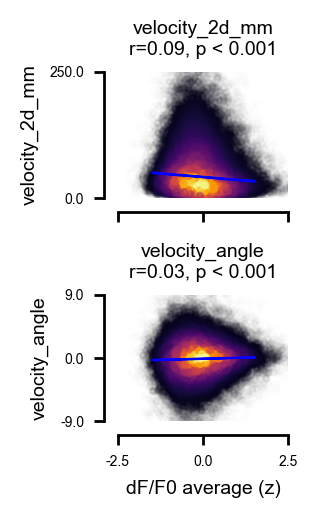

In [22]:
xvals = np.linspace(-1.5, 1.5, 50)

fig, ax = plt.subplots(
    len(ys), len(xs), figsize=(1.6 * len(xs), 1.3 * len(ys)), sharex=True, sharey="row"
)
if len(ys) == 1:
    ax = np.array([ax])
for _y, rax in tqdm(zip(ys, ax), total=len(ys)):
    if len(xs) == 1:
        rax = [rax]
    for _x, _ax in tqdm(zip(xs, rax), total=len(xs)):

        x, y = plt_points.dropna()[_x].values, plt_points.dropna()[_y].values
        z = get_z(x, y, 1)
        z /= z.max()
        _ax.scatter(
            x, y, c=z, s=5, cmap="inferno", alpha=np.clip(z, 0, 0.75), rasterized=True
        )

        clf = linear_model.HuberRegressor(fit_intercept=True, epsilon=1.05)
        delays = [
            delayed(model_fit)(
                plt_points,
                shuffle_splits,
                clf=clf,
                shuffle_x=True,
                partial_x=partial_vars,
                y=_y,
                x=_x,
            )
            for i in range(nshuffles)
        ]

        results = Parallel(n_jobs=-1, verbose=0)(delays)

        obs_r, models, (plt_x, plt_y) = model_fit(
            plt_points,
            obs_splits,
            clf=clf,
            return_models=True,
            partial_x=partial_vars,
            y=_y,
            x=_x,
            return_input=True,
        )
        p = (obs_r < results).mean()

        use_field = f"{_x}-{_y}"
        stats[use_field] = {}
        stats[use_field]["r"] = obs_r
        stats[use_field]["p"] = p
        stats[use_field]["regressor"] = str(clf)
        stats[use_field]["n"] = len(plt_points)
        stats[use_field]["n_definition"] = "n bins"

        predictions = np.array([_.predict(xvals.reshape(-1, 1)) for _ in models])
        regression_ci = np.quantile(predictions, [0.025, 0.975], axis=0)

        _ax.fill_between(
            xvals, regression_ci[0], regression_ci[1], color="b", zorder=+300
        )
        _ax.set_title(f"{_y}\nr={obs_r:.2f}, {format_pval(p)[0]}")

        try:
            _ax.set_ylim(lims[_y])
        except KeyError:
            pass

        clean_ticks(_ax, "y", precision=1, zero_symmetry=False)

    rax[0].set_ylabel(_y)

# plt.ylim(-1.5, 1.5)
plt.xlim(-2, 2.5)
clean_ticks(ax, "x", precision=1)
sns.despine(offset=5)
ax[-1].set_xlabel("dF/F0 average (z)")
fig.tight_layout()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "dlight_syllable_binned_scalars_kde"),
    bbox_inches="tight",
    dpi=900,
)

In [23]:
stats["stat_type"] = "Pearson correlation (heldout)"
stats["p_type"] = "Comparison to shuffle"

In [24]:
with open(os.path.join(proc_dirs["dlight"], "stats_binned_scalars.toml"), "w") as f:
    toml.dump(stats, f)

In [25]:
stats

{'signal_reref_dff_z-velocity_2d_mm': {'r': 0.0869321141929803,
  'p': 0.0,
  'regressor': 'HuberRegressor(epsilon=1.05)',
  'n': 28000,
  'n_definition': 'n bins'},
 'signal_reref_dff_z-velocity_angle': {'r': 0.03075149683491898,
  'p': 0.0,
  'regressor': 'HuberRegressor(epsilon=1.05)',
  'n': 28000,
  'n_definition': 'n bins'},
 'stat_type': 'Pearson correlation (heldout)',
 'p_type': 'Comparison to shuffle'}